# Pairs Trading Strategy: Correlation Screening + Cointegration Testing

## Overview
This notebook implements a complete pairs trading pipeline that:
1. **Screens** potential pairs using correlation analysis
2. **Validates** candidates with rigorous cointegration testing
3. **Backtests** the strategy with proper train/test split
4. **Evaluates** performance with industry-standard metrics

### Why Correlation + Cointegration?
- **Correlation** helps narrow down candidates quickly
- **Cointegration** ensures the spread is actually mean-reverting

**Author**: Rush Shah  
**Date**: December 2025

---
## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

---
## 2. Configuration

**Choose your target stock and sector peers below.**

The strategy will:
1. Build a correlation matrix across all candidates
2. Test cointegration on highly correlated pairs
3. Select the best pair that passes statistical tests

In [2]:
TARGET_STOCK = 'MNST'
PEER_STOCKS = ['BUD', 'STZ', 'SAM', 'TAP', 'CELH', 'PEP', 'KO', 'KDP','ABEV', 'MGPI', 'WVVI', 'SBUX']

# Combine into full list
ALL_TICKERS = [TARGET_STOCK] + PEER_STOCKS

# Date range
START_DATE = '2022-01-01'
END_DATE = '2024-06-01'

# Train/Test split
TRAIN_RATIO = 0.70

# Cointegration threshold
COINT_PVALUE_THRESHOLD = 0.05
MIN_CORRELATION = 0.70  # Only test pairs with correlation above this

# Trading parameters
ENTRY_ZSCORE = 2.0
EXIT_ZSCORE = 0.0
STOP_LOSS_ZSCORE = 3.5
LOOKBACK_WINDOW = 60

INITIAL_CAPITAL = 100000

print(f"Target Stock: {TARGET_STOCK}")
print(f"Peer Candidates: {PEER_STOCKS}")

Target Stock: MNST
Peer Candidates: ['BUD', 'STZ', 'SAM', 'TAP', 'CELH', 'PEP', 'KO', 'KDP', 'ABEV', 'MGPI', 'WVVI', 'SBUX']


---
## 3. Data Collection

In [3]:
# Download data for all tickers
data = yf.download(ALL_TICKERS, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)['Close']
data = data.dropna()

print("=" * 40)
print(f"(Trading days, stocks): {data.shape}")
print(f"Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
print("=" * 40)
data.tail()

(Trading days, stocks): (606, 13)
Date range: 2022-01-03 to 2024-05-31


Ticker,ABEV,BUD,CELH,KDP,KO,MGPI,MNST,PEP,SAM,SBUX,STZ,TAP,WVVI
Date,,,,,,,,,,,,,
2024-05-24,2.107640,63.930927,95.150002,32.769650,58.905849,73.722542,52.700001,167.105453,260.750000,75.899200,240.321716,50.368229,4.10
2024-05-28,2.052418,62.427013,82.919998,32.309589,58.734825,73.898941,51.650002,162.777359,259.510010,74.561539,237.401230,49.859844,4.19
2024-05-29,2.024806,61.217991,79.809998,32.261669,58.620815,73.124763,52.130001,160.683746,255.869995,73.984146,235.931290,49.916328,4.18
2024-05-30,2.034010,61.267139,78.699997,32.491695,58.877338,74.967087,51.240002,160.054703,256.410004,75.793327,238.464966,50.104626,4.02
2024-05-31,2.043214,61.994518,79.980003,32.827156,59.789436,76.064651,51.919998,162.326721,313.670013,77.198334,241.985031,51.601547,4.00


In [4]:
# Split into train/test
split_idx = int(len(data) * TRAIN_RATIO)
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

print("=" * 45)
print(f"Training: {len(train_data)} days ({train_data.index[0].strftime('%Y-%m-%d')} to {train_data.index[-1].strftime('%Y-%m-%d')})")
print(f"Testing:  {len(test_data)} days ({test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')})")
print("=" * 45)

Training: 424 days (2022-01-03 to 2023-09-11)
Testing:  182 days (2023-09-12 to 2024-05-31)


---
## 4. Step 1: Correlation Matrix Screening

First, we build a correlation matrix to identify which pairs move together. High correlation is necessary (but not sufficient!) for pairs trading.

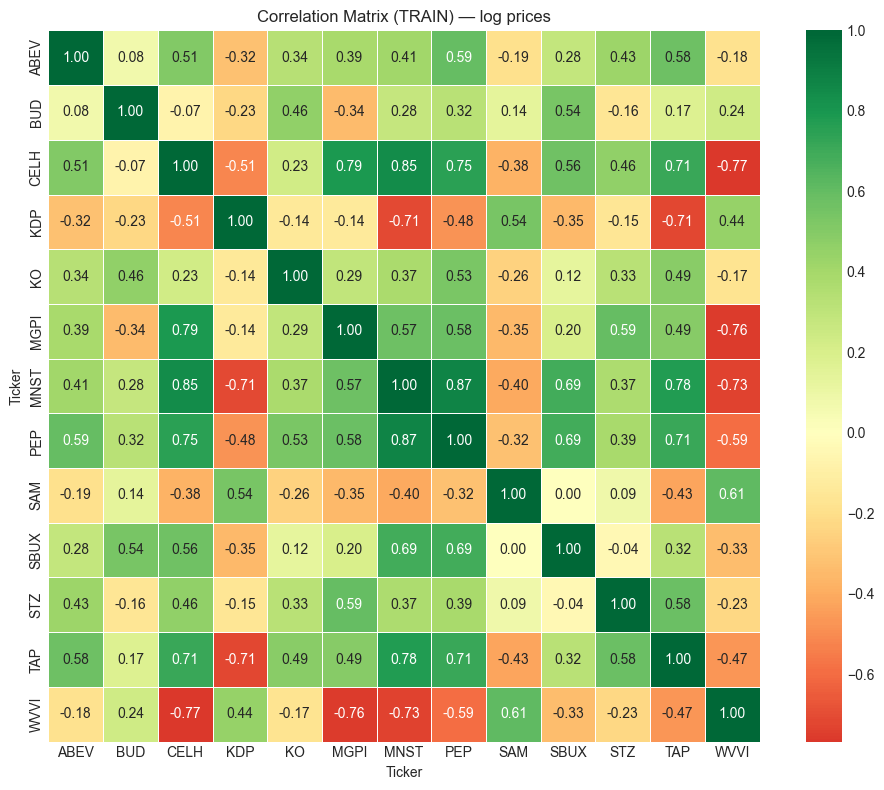

In [5]:
# Calculate correlation matrices on TRAINING data only
log_train_prices = np.log(train_data)
price_corr = log_train_prices.corr()
corr_matrix = price_corr

# Visualize: log-price correlation
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(price_corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=0.5, ax=ax)
ax.set_title("Correlation Matrix (TRAIN) — log prices")
plt.tight_layout()
plt.show()

In [6]:
# Extract correlations with target stock
target_correlations = corr_matrix[TARGET_STOCK].drop(TARGET_STOCK).sort_values(ascending=False)

print("=" * 25)
print(f"Correlations with {TARGET_STOCK}:")
print("=" * 25)
for ticker, corr in target_correlations.items():
    status = "✓ HIGH" if corr >= MIN_CORRELATION else "  low"
    print(f"{ticker:6} | {corr:6.3f} | {status}")

# Filter candidates
high_corr_candidates = target_correlations[target_correlations >= MIN_CORRELATION].index.tolist()
print("=" * 60)
print(f"Candidates with correlation >= {MIN_CORRELATION}: {high_corr_candidates}")
print("=" * 60)

Correlations with MNST:
PEP    |  0.874 | ✓ HIGH
CELH   |  0.846 | ✓ HIGH
TAP    |  0.775 | ✓ HIGH
SBUX   |  0.694 |   low
MGPI   |  0.574 |   low
ABEV   |  0.408 |   low
KO     |  0.374 |   low
STZ    |  0.368 |   low
BUD    |  0.279 |   low
SAM    | -0.405 |   low
KDP    | -0.708 |   low
WVVI   | -0.734 |   low
Candidates with correlation >= 0.7: ['PEP', 'CELH', 'TAP']


---
## 5. Step 2: Cointegration Testing

Now we test each high-correlation pair for cointegration. Correlation alone doesn't mean the spread will mean-revert.

We use the **Engle-Granger test**:
- Null hypothesis: No cointegration
- If p-value < 0.05: Reject null → pair IS cointegrated

In [7]:
def test_pair_cointegration(series1, series2, name1, name2):
    """
    Consistent Engle–Granger (TRAIN only):
    1) OLS on log prices: log(y) = alpha + beta*log(x) + eps
    2) spread = residual eps (includes intercept)
    3) ADF test on residual spread -> p-value is our cointegration test
    4) Half-life from AR(1) on spread: s_t = c + phi*s_{t-1} + e ; HL = -ln2 / ln(phi)
    """
    # Align and log-transform prices
    df = pd.concat([series1, series2], axis=1).dropna()
    y_price = df.iloc[:, 0]
    x_price = df.iloc[:, 1]
    y = np.log(y_price)
    x = np.log(x_price)

    # Step 1: OLS
    X = add_constant(x)
    model = OLS(y, X).fit()
    alpha = float(model.params.iloc[0])
    beta = float(model.params.iloc[1])

    # Step 2: residual spread (intercept-aware)
    spread = y - (alpha + beta * x)
    spread.name = "spread"

    # Step 3: ADF on residual spread (this is the EG cointegration test)
    adf_stat, adf_pvalue, _, _, adf_crit, _ = adfuller(spread.dropna(), regression="c", autolag="AIC")

    # Step 4: half-life from AR(1) phi
    s_lag = spread.shift(1)
    ar_df = pd.concat([spread, s_lag], axis=1).dropna()
    if len(ar_df) >= 10:
        y_ar = ar_df.iloc[:, 0]
        x_ar = ar_df.iloc[:, 1]
        ar_model = OLS(y_ar, add_constant(x_ar)).fit()
        phi = float(ar_model.params.iloc[1])
        if (not np.isfinite(phi)) or phi <= 0:
            half_life = np.nan
        elif phi >= 1:
            half_life = np.inf
        else:
            half_life = float(-np.log(2.0) / np.log(phi))
    else:
        half_life = np.nan

    # Report correlation
    price_corr = float(y_price.corr(x_price))

    return {
        'pair': f"{name1}/{name2}",
        'ticker1': name1,
        'ticker2': name2,
        'correlation': price_corr,
        'coint_pvalue': float(adf_pvalue),
        'coint_stat': float(adf_stat),
        'hedge_ratio': float(beta),
        'alpha': float(alpha),
        'beta': float(beta),
        'half_life': half_life,
        'is_cointegrated': float(adf_pvalue) < COINT_PVALUE_THRESHOLD
    }

In [8]:
# Test cointegration for all candidate pairs
results = []

print("=" * 75)

if len(high_corr_candidates) == 0:
    print("No candidates passed the correlation screen.")
    print("Try lowering MIN_CORRELATION or changing the peer list / time window.")
    results_df = pd.DataFrame(columns=[
        'pair','ticker1','ticker2','correlation','logret_corr',
        'coint_pvalue','coint_stat','hedge_ratio','alpha','beta',
        'half_life','is_cointegrated']
    )
else:
    for candidate in high_corr_candidates:
        result = test_pair_cointegration(
            train_data[TARGET_STOCK],
            train_data[candidate],
            TARGET_STOCK,
            candidate
        )
        results.append(result)

        status = "COINTEGRATED" if result['is_cointegrated'] else "Not cointegrated"
        print(f"{result['pair']:12} | price corr: {result['correlation']:.3f} | coint p-val: {result['coint_pvalue']:.4f} | {status}")

    results_df = pd.DataFrame(results)

print("=" * 75)
results_df

MNST/PEP     | price corr: 0.877 | coint p-val: 0.0302 | COINTEGRATED
MNST/CELH    | price corr: 0.832 | coint p-val: 0.1863 | Not cointegrated
MNST/TAP     | price corr: 0.798 | coint p-val: 0.0975 | Not cointegrated


,pair,ticker1,ticker2,correlation,coint_pvalue,coint_stat,hedge_ratio,alpha,beta,half_life,is_cointegrated
0,MNST/PEP,MNST,PEP,0.876926,0.030161,-3.053869,1.868555,-5.575748,1.868555,15.467966,True
1,MNST/CELH,MNST,CELH,0.832408,0.186323,-2.256671,0.274821,2.954597,0.274821,27.584612,False
2,MNST/TAP,MNST,TAP,0.798108,0.097540,-2.578419,0.846395,0.580735,0.846395,21.727954,False


In [9]:
# Filter cointegrated pairs
if len(results_df) == 0:
    cointegrated_pairs = results_df.copy()
    print("No results to evaluate (no candidates were tested).")
else:
    cointegrated_pairs = results_df[results_df['is_cointegrated']].copy()

    if len(cointegrated_pairs) == 0:
        print("NO COINTEGRATED PAIRS FOUND!")
        print("\nOptions:")
        print("1. Try a different target stock or sector")
        print("2. Lower the correlation threshold")
        print("3. Use a different time period")
        print("\nClosest (lowest ADF p-value) was:")
        best = results_df.loc[results_df['coint_pvalue'].idxmin()]
        print(f"   {best['pair']} with p-value = {best['coint_pvalue']:.4f}")
    else:
        print("=" * 30)
        print(f"Found {len(cointegrated_pairs)} cointegrated pair(s)")
        print("=" * 30)
        for _, row in cointegrated_pairs.iterrows():
            print(f"{row['pair']}:")
            print(f"  Price Corr: {row['correlation']:.3f}")
            print(f"  EG (ADF) p-value: {row['coint_pvalue']:.4f}")
            print(f"  beta (log-space): {row['beta']:.4f}")
            print(f"  Half-life: {row['half_life']:.1f} days")
            print("=" * 30)

Found 1 cointegrated pair(s)
MNST/PEP:
  Price Corr: 0.877
  EG (ADF) p-value: 0.0302
  beta (log-space): 1.8686
  Half-life: 15.5 days


In [10]:
# Select the best pair (lowest p-value among cointegrated pairs)
if len(cointegrated_pairs) > 0:
    best_pair = cointegrated_pairs.loc[cointegrated_pairs['coint_pvalue'].idxmin()]

    TICKER_1 = best_pair['ticker1']
    TICKER_2 = best_pair['ticker2']
    ALPHA = best_pair['alpha']
    BETA = best_pair['beta']

    # Keep legacy name for downstream cells
    HEDGE_RATIO = BETA

    print("=" * 25)
    print("SELECTED PAIR")
    print("=" * 25)
    print(f"Pair: {TICKER_1} / {TICKER_2}")
    print(f"Price Corr: {best_pair['correlation']:.3f}")
    print(f"Coint p-value: {best_pair['coint_pvalue']:.4f}")
    print(f"alpha: {ALPHA:+.6f}")
    print(f"beta : {BETA:+.6f}")
    print(f"Half-life: {best_pair['half_life']:.1f} days")
    print("=" * 25)
else:
    print("Cannot proceed without a cointegrated pair.")
    print("Please modify the configuration and try a different sector.")

SELECTED PAIR
Pair: MNST / PEP
Price Corr: 0.877
Coint p-value: 0.0302
alpha: -5.575748
beta : +1.868555
Half-life: 15.5 days


---
## 6. Visualize the Selected Pair

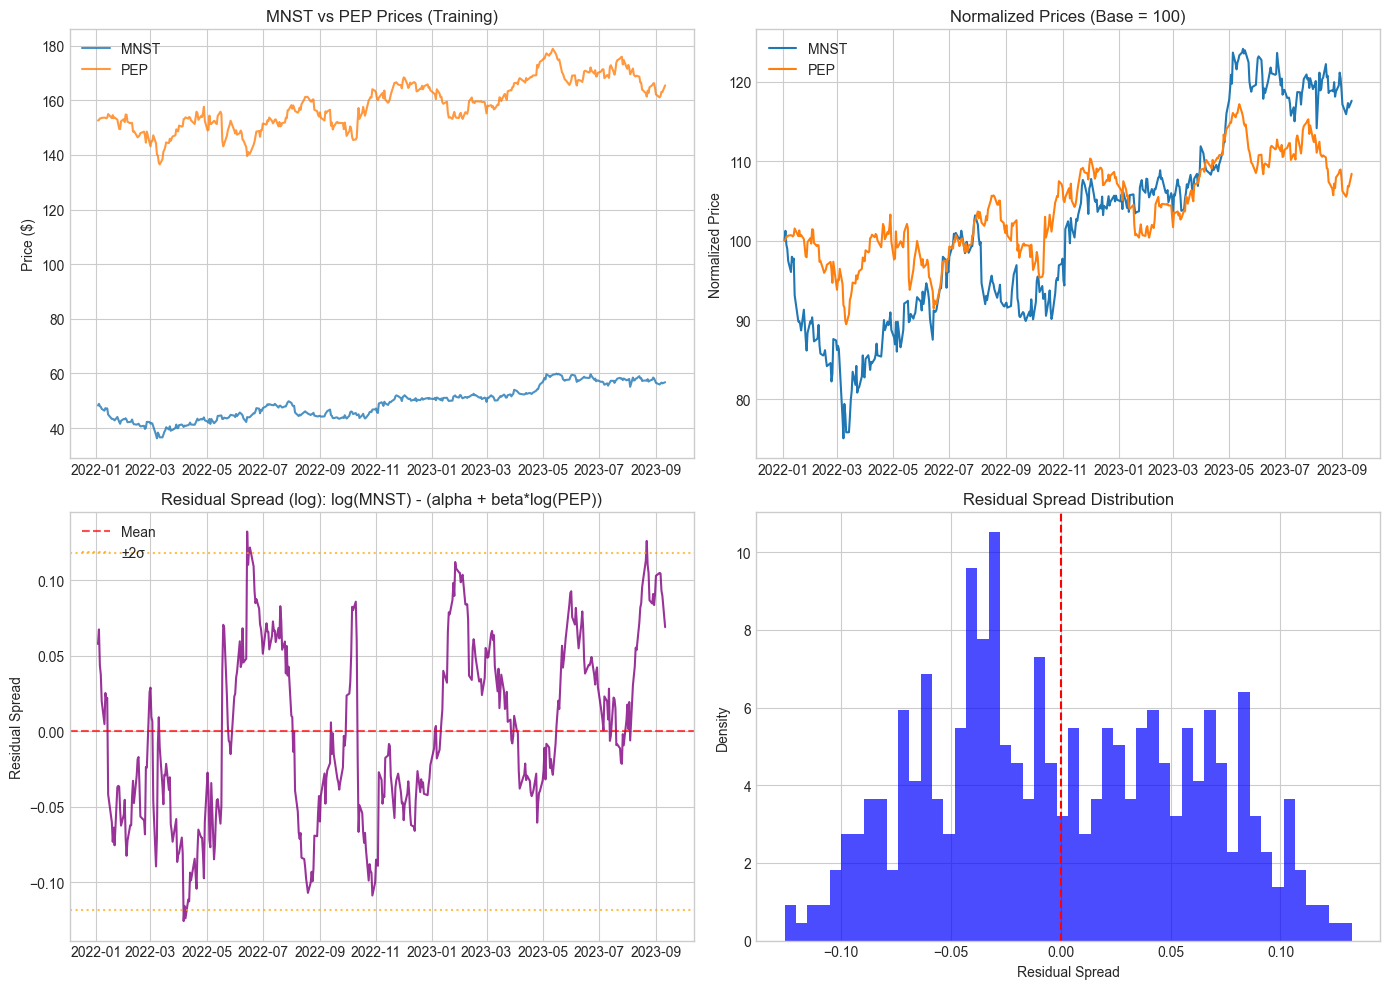

In [11]:
# Only runs if we found a cointegrated pair
if len(cointegrated_pairs) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Price series
    ax1 = axes[0, 0]
    ax1.plot(train_data.index, train_data[TICKER_1], label=TICKER_1, alpha=0.8)
    ax1.plot(train_data.index, train_data[TICKER_2], label=TICKER_2, alpha=0.8)
    ax1.set_title(f'{TICKER_1} vs {TICKER_2} Prices (Training)')
    ax1.set_ylabel('Price ($)')
    ax1.legend()

    # Normalized prices
    ax2 = axes[0, 1]
    norm1 = train_data[TICKER_1] / train_data[TICKER_1].iloc[0] * 100
    norm2 = train_data[TICKER_2] / train_data[TICKER_2].iloc[0] * 100
    ax2.plot(train_data.index, norm1, label=TICKER_1)
    ax2.plot(train_data.index, norm2, label=TICKER_2)
    ax2.set_title('Normalized Prices (Base = 100)')
    ax2.set_ylabel('Normalized Price')
    ax2.legend()

    # Residual spread (log-space, intercept-aware)
    ax3 = axes[1, 0]
    log1 = np.log(train_data[TICKER_1])
    log2 = np.log(train_data[TICKER_2])
    spread = log1 - (ALPHA + BETA * log2)
    ax3.plot(train_data.index, spread, color='purple', alpha=0.8)
    ax3.axhline(spread.mean(), color='red', linestyle='--', alpha=0.7, label='Mean')
    ax3.axhline(spread.mean() + 2*spread.std(), color='orange', linestyle=':', alpha=0.7, label='±2σ')
    ax3.axhline(spread.mean() - 2*spread.std(), color='orange', linestyle=':', alpha=0.7)
    ax3.set_title(f'Residual Spread (log): log({TICKER_1}) - (alpha + beta*log({TICKER_2}))')
    ax3.set_ylabel('Residual Spread')
    ax3.legend()

    # Spread distribution
    ax4 = axes[1, 1]
    ax4.hist(spread.dropna(), bins=50, density=True, alpha=0.7, color='blue')
    ax4.axvline(spread.mean(), color='red', linestyle='--')
    ax4.set_title('Residual Spread Distribution')
    ax4.set_xlabel('Residual Spread')
    ax4.set_ylabel('Density')

    plt.tight_layout()
    plt.show()

---
## 7. Signal Generation & Backtesting

In [12]:
def generate_signals(data, ticker1, ticker2, alpha, beta, lookback, entry_z, exit_z, stop_z):
    """Generate trading signals based on rolling z-score of residual spread (log-space)."""
    df = data[[ticker1, ticker2]].copy().dropna()

    # residual spread in log space (intercept-aware)
    log1 = np.log(df[ticker1])
    log2 = np.log(df[ticker2])
    df['spread'] = log1 - (alpha + beta * log2)

    # Rolling z-score
    df['spread_mean'] = df['spread'].rolling(window=lookback).mean()
    df['spread_std'] = df['spread'].rolling(window=lookback).std(ddof=0)
    df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

    # Generate positions
    position = 0
    positions = []

    for z in df['zscore']:
        if pd.isna(z):
            positions.append(0)
            position = 0
            continue

        if position == 0:
            if z < -entry_z:
                position = 1
            elif z > entry_z:
                position = -1
        elif position == 1:
            if z >= exit_z or z < -stop_z:
                position = 0
        elif position == -1:
            if z <= exit_z or z > stop_z:
                position = 0

        positions.append(position)

    df['position'] = positions
    df['position_change'] = df['position'].diff().fillna(0)
    return df

def backtest(df, ticker1, ticker2, beta, initial_capital):
    """Simple backtest using log-return approximation with normalized weights from beta (gross=1)."""
    results = df.copy()

    # log returns
    results['r1'] = np.log(results[ticker1]).diff()
    results['r2'] = np.log(results[ticker2]).diff()

    mag = abs(float(beta))
    w1 = 1.0 / (1.0 + mag)
    w2 = mag / (1.0 + mag)

    pos_prev = results['position'].shift(1).fillna(0.0)
    # Long spread: +w1*r1 - w2*r2
    results['strategy_return'] = pos_prev * (w1 * results['r1'] - w2 * results['r2'])
    results['strategy_return'] = results['strategy_return'].fillna(0.0)

    results['cumulative_return'] = (1 + results['strategy_return']).cumprod()
    results['equity'] = initial_capital * results['cumulative_return']
    return results

def calculate_metrics(results, initial_capital):
    returns = results['strategy_return'].dropna()
    equity = results['equity'].dropna()

    total_return = (equity.iloc[-1] / initial_capital - 1) * 100
    trading_days = len(returns)
    years = trading_days / 252 if trading_days > 0 else np.nan

    ann_return = ((1 + total_return/100) ** (1/years) - 1) * 100 if years and years > 0 else np.nan
    ann_vol = returns.std(ddof=0) * np.sqrt(252) * 100 if trading_days > 1 else np.nan
    sharpe = ann_return / ann_vol if ann_vol and ann_vol > 0 else np.nan

    rolling_max = equity.cummax()
    drawdown = (equity - rolling_max) / rolling_max
    max_dd = drawdown.min() * 100

    positions = results['position']
    in_position = returns[positions.shift(1) != 0]
    win_rate = (in_position > 0).sum() / len(in_position) * 100 if len(in_position) > 0 else np.nan

    return {
        'Total Return (%)': total_return,
        'Annualized Return (%)': ann_return,
        'Annualized Volatility (%)': ann_vol,
        'Sharpe Ratio': sharpe,
        'Maximum Drawdown (%)': max_dd,
        'Win Rate (%) (daily)': win_rate,
        'Time in Market (%)': (positions != 0).mean() * 100
    }

def plot_results(results, ticker1, ticker2):
    fig, axes = plt.subplots(4, 1, figsize=(14, 16))
    fig.suptitle(f'Pairs Trading (Notebook Demo): {ticker1}/{ticker2}', fontsize=14, fontweight='bold')

    ax1 = axes[0]
    ax1.plot(results.index, results[ticker1], label=ticker1, alpha=0.8)
    ax1.plot(results.index, results[ticker2], label=ticker2, alpha=0.8)
    ax1.set_title('Price Series (Test Period)')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2 = axes[1]
    ax2.plot(results.index, results['zscore'], color='blue', alpha=0.7, label='Z-Score')
    ax2.axhline(ENTRY_ZSCORE, color='red', linestyle='--', label=f'Entry (±{ENTRY_ZSCORE})')
    ax2.axhline(-ENTRY_ZSCORE, color='red', linestyle='--')
    ax2.axhline(0, color='black', linestyle='-', alpha=0.5)
    ax2.axhline(STOP_LOSS_ZSCORE, color='orange', linestyle=':', label=f'Stop (±{STOP_LOSS_ZSCORE})')
    ax2.axhline(-STOP_LOSS_ZSCORE, color='orange', linestyle=':')
    ax2.set_title('Z-Score (Residual Spread)')
    ax2.set_ylabel('Z-Score')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    ax3 = axes[2]
    ax3.plot(results.index, results['equity'], label='Equity', linewidth=2)
    ax3.axhline(INITIAL_CAPITAL, color='black', linestyle='--', alpha=0.5, label='Initial Capital')
    ax3.set_title('Equity Curve (Demo)')
    ax3.set_ylabel('Portfolio Value ($)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    ax4 = axes[3]
    rolling_max = results['equity'].cummax()
    drawdown = (results['equity'] - rolling_max) / rolling_max * 100
    ax4.fill_between(results.index, 0, drawdown, alpha=0.5)
    ax4.set_title('Drawdown')
    ax4.set_ylabel('Drawdown (%)')
    ax4.set_xlabel('Date')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [13]:
# Runs backtest (only if we have a cointegrated pair)
if len(cointegrated_pairs) > 0:
    # Generate signals on TEST data
    test_signals = generate_signals(
        test_data, TICKER_1, TICKER_2, ALPHA, BETA,
        LOOKBACK_WINDOW, ENTRY_ZSCORE, EXIT_ZSCORE, STOP_LOSS_ZSCORE
    )

    # Run backtest (demo). For your main results, use the separate Python backtest engine.
    results = backtest(test_signals, TICKER_1, TICKER_2, BETA, INITIAL_CAPITAL)

    # Calculate metrics
    metrics = calculate_metrics(results, INITIAL_CAPITAL)

    print("=" * 45)
    print(f"BACKTEST RESULTS (Notebook Demo): {TICKER_1}/{TICKER_2}")
    print("=" * 45)
    for key, value in metrics.items():
        if isinstance(value, float) and np.isfinite(value):
            if 'Ratio' in key:
                print(f"{key:30} {value:>10.3f}")
            elif '%' in key:
                print(f"{key:30} {value:>10.2f}%")
            else:
                print(f"{key:30} {value:>10.2f}")
        else:
            print(f"{key:30} {value}")
    print("=" * 45)
else:
    print("Skipping backtest demo (no selected pair).")

BACKTEST RESULTS (Notebook Demo): MNST/PEP
Total Return (%)                     2.66%
Annualized Return (%)                3.70%
Annualized Volatility (%)            6.39%
Sharpe Ratio                        0.579
Maximum Drawdown (%)                -4.37%
Win Rate (%) (daily)                50.00%
Time in Market (%)                  29.67%


---
## 8. Results Visualization

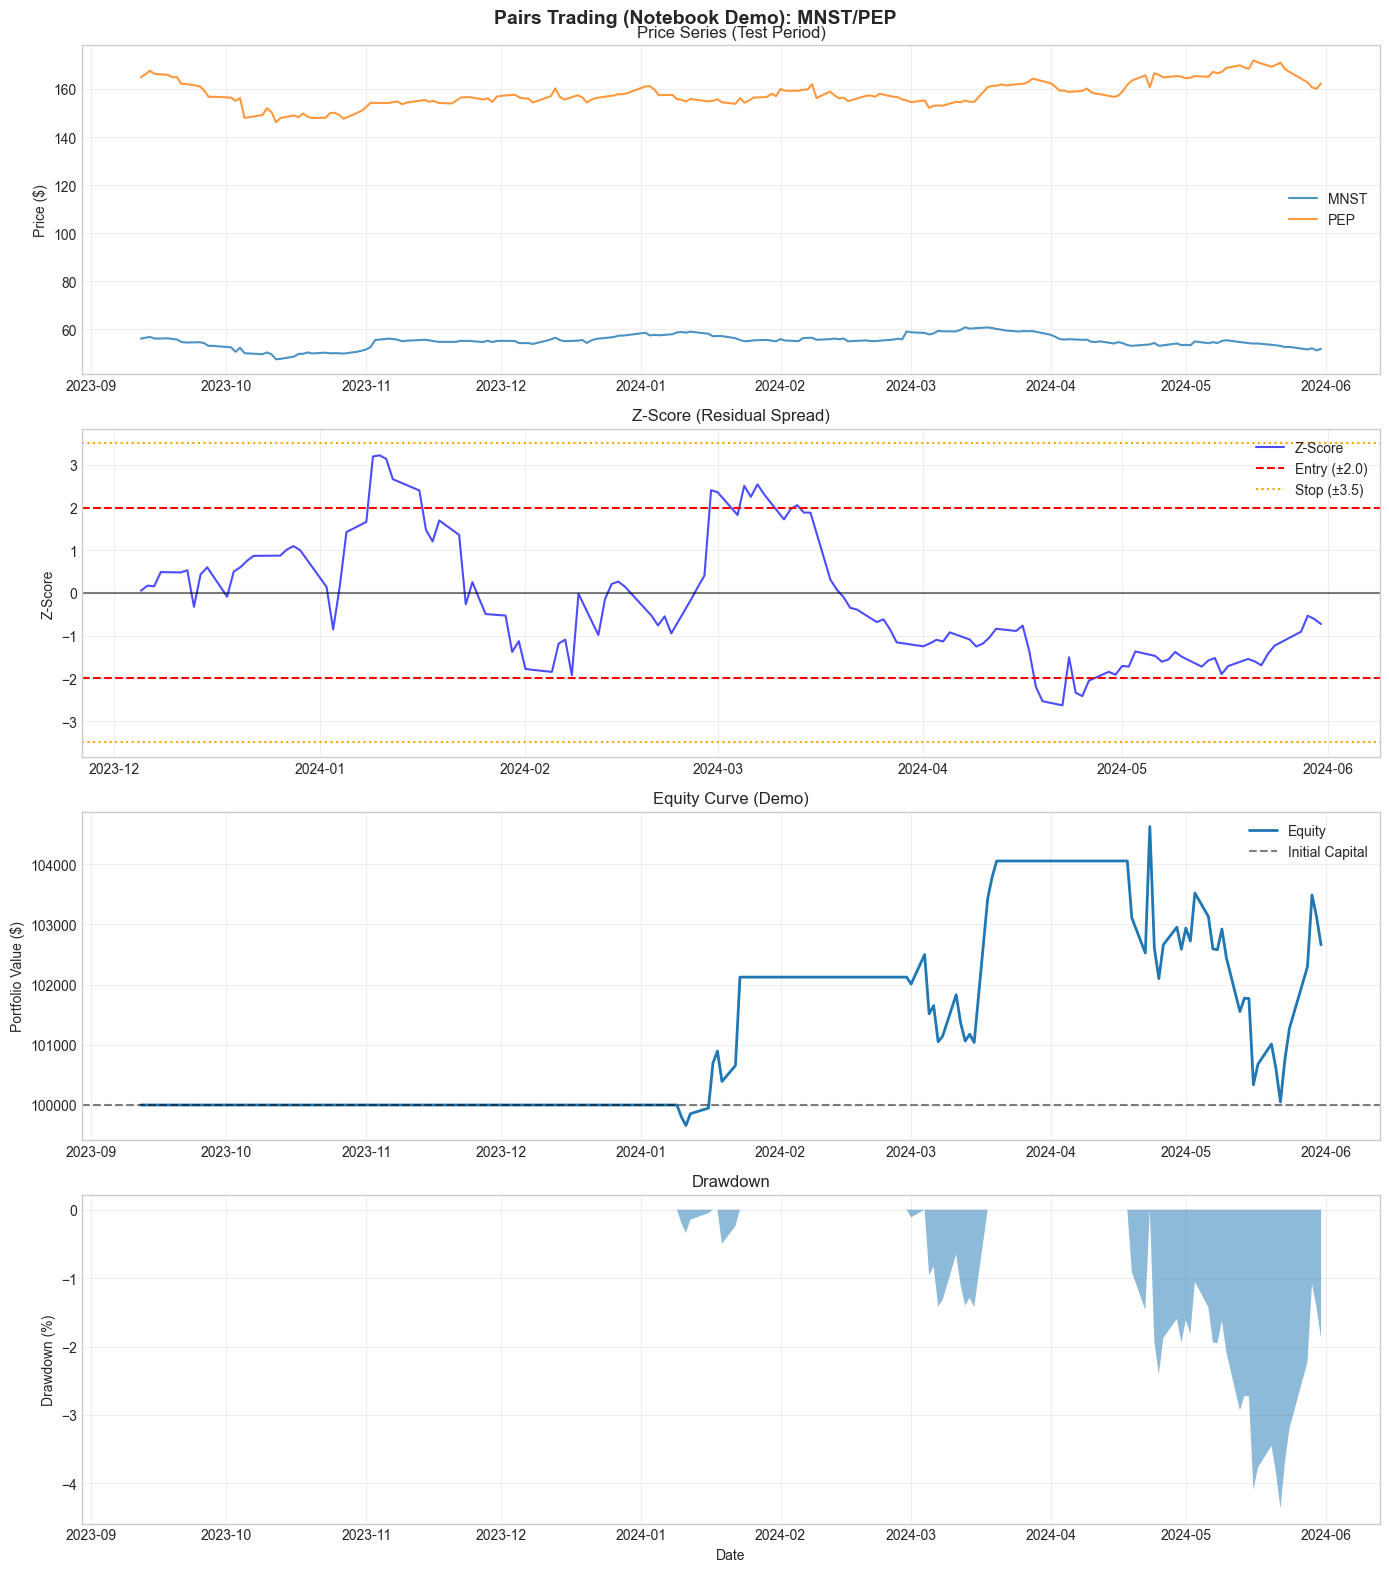

In [14]:
# Results Visualization (Notebook Demo)
if 'results' in globals() and isinstance(results, pd.DataFrame) and len(results) > 0:
    plot_results(results, TICKER_1, TICKER_2)
else:
    print("No backtest results to plot in this notebook. (Run the demo backtest cell first.)")

---
## 9. Summary

### Methodology
1. **Screened** sector peers using correlation matrix
2. **Tested** high-correlation pairs for cointegration (Engle-Granger test)
3. **Selected** the pair with lowest p-value that passed significance threshold
4. **Backtested** on out-of-sample data with z-score entry/exit rules

### Key Insight
**Correlation ≠ Cointegration**. Two stocks can be highly correlated but NOT mean-reverting. The cointegration test ensures the spread will actually revert to the mean, which is essential for pairs trading.

### Limitations
- Transaction costs not included
- Slippage not modeled
- Cointegration can break down over time

### Future Improvements
- Dynamic hedge ratio (Kalman filter)
- Rolling cointegration monitoring
- Multi-pair portfolio

In [15]:
# Save results
if len(cointegrated_pairs) > 0:
    results.to_csv('pairs_trading_results.csv')
    results_df.to_csv('cointegration_screening_results.csv', index=False)
    print("Results saved to CSV files.")

Results saved to CSV files.
